# Plotting and Analyzing the Helium-Graphene Potential

In [14]:
# %load ../include/header.py
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import joblib 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π
import heprops

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Some helper and analysis functions

In [2]:
import layerutils
importlib.reload(layerutils)
from layerutils import lab,vals,texformat

## The Graphene Lattice

In [15]:
strain = 0.25 # Strain value in armchair direction
Am, An, b1, b2, gm, gn = gt.get_graphene_vectors(strain)

In [16]:
cδ = 0.25
a,b = gt.get_graphene_carbon_atoms(cδ,[4,4])
carbon_atoms = np.vstack([a,b])
N_C = len(carbon_atoms)
aₒ = 1.42
Lx,Ly = np.max(carbon_atoms[:,0]),np.max(carbon_atoms[:,1])

### Diagram of a Single Strained Hexagon

(-1.2969314988819522, 1.2969314988819522, -1.9524999999999995, 1.9525)

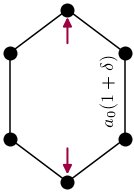

In [7]:
fig,ax = plt.subplots(figsize=(1.0,1.4), constrained_layout=True)

for i in range(N_C):
    ax.plot(carbon_atoms[i,0],carbon_atoms[i,1],'o', ms=6, color='k')
    
for i in range(N_C):
    for j in range(i+1,N_C):
        r = carbon_atoms[i]-carbon_atoms[j]
        if np.abs(np.sqrt(r[0]**2 + r[1]**2) - aₒ*(1+cδ)) < 0.3:
            ax.plot([carbon_atoms[i,0],carbon_atoms[j,0]],[carbon_atoms[i,1],carbon_atoms[j,1]], 'k-', lw=0.75)
            
ax.text(0.85,0.1,r'$a_0(1+\delta)$', rotation=90, va='center', ha='center')

ax.annotate("", xy=(0, 1.7), xytext=(0, 1.0), arrowprops=dict(arrowstyle="-|>",color=colors[-1]))
ax.annotate("", xy=(0, -1.7), xytext=(0, -1.0), arrowprops=dict(arrowstyle="-|>",color=colors[-1]))

ax.axis('equal')
ax.axis('off')

## Get the adsorption potential as a function of strain and plot

In [8]:
δlab = lambda δ: f'δ = {δ:4.2f}'

In [9]:
%%time
# Generate a 1D potential along z-direction at specific (x,y) location
δ = [0.0,0.05,0.10,0.15,0.2,0.25]
Vz = {}
x,y, = 0.0,0.0
z = gt.np.linspace(2.1,5,501)

for cδ in δ:
    Vz[δlab(cδ)] = gt.generate_V1D(x,y,z,strain=cδ)

CPU times: user 58.9 s, sys: 536 ms, total: 59.4 s
Wall time: 1min


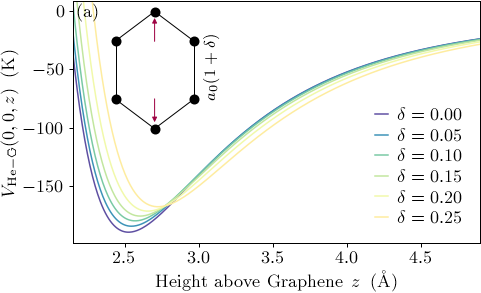

In [10]:
fig,ax = plt.subplots(figsize=figsize, constrained_layout=True)

for i,cδ in enumerate(δ):
    ax.plot(z,Vz[δlab(cδ)], label=f'$\delta = {cδ:.2f}$', lw=0.75, color=colors[i])
    
ax.set_xlim(2.15,4.9)
ax.set_ylim(-199,9)

ax.set_xlabel(r'Height above Graphene  $\alabel{z}{\angstrom}$')
ax.set_ylabel(r'$\alabel{V_{\rm He-\graphene}(0,0,z)}{\kelvin}$')

ax.legend(handlelength=0.75)

## Add inset showing strain
Lx = 1.1790286353472292
Ly = 1.775
axs = ax.inset_axes([0.05, 0.45, 0.3,0.35*Ly/Lx])

for i in range(N_C):
    axs.plot(carbon_atoms[i,0],carbon_atoms[i,1],'o', ms=4, color='k')
    
for i in range(N_C):
    for j in range(i+1,N_C):
        r = carbon_atoms[i]-carbon_atoms[j]
        if np.abs(np.sqrt(r[0]**2 + r[1]**2) - aₒ*(1+cδ)) < 0.3:
            axs.plot([carbon_atoms[i,0],carbon_atoms[j,0]],[carbon_atoms[i,1],carbon_atoms[j,1]], 'k-', lw=0.5)
            
axs.text(1.75,0.1,r'$a_0(1+\delta)$', rotation=90, va='center', ha='center', fontsize=8)

axs.annotate("", xy=(0, 1.7), xytext=(0, 0.75), arrowprops=dict(arrowstyle="-|>",lw=0.5, mutation_scale=5,color=colors[-1]))
axs.annotate("", xy=(0, -1.7), xytext=(0, -0.75), arrowprops=dict(arrowstyle="-|>",lw=0.5, mutation_scale=5,color=colors[-1]))

axs.axis('equal')
axs.axis('off')

ax.text(0.01,0.99,'(a)',ha='left',va='top',transform=ax.transAxes)


plt.savefig('../plots/Vgraphene_vs_z_anistrain.pdf')

### Effects of Strain on Hopping

In [11]:
δ,t_par,t_perp = np.loadtxt('../data/hopping_ani_strain.dat', unpack=True)
δJV,V_par,V_perp = np.loadtxt('../data/VBH_DFT_ani_strain.dat', unpack=True)

Text(0.01, 0.99, '(c)')

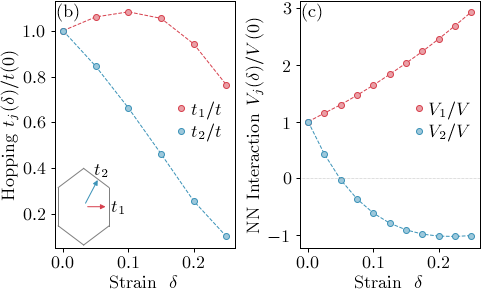

In [12]:
fig,axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=False, 
                      figsize=figsize, constrained_layout=True)
axes[0].plot(δ,t_perp/t_perp[0], 'o', color=colors[-2], lw=0.5, ls='--', ms=3, label=r'$t_{1}/t$',
        mfc=colortools.get_alpha_hex(colors[-2],0.5), mec=colors[-2], mew=0.5)
axes[0].plot(δ,t_par/t_par[0], 'o', color=colors[1], lw=0.5, ls='--', ms=3, label=r'$t_2/t$', 
       mfc=colortools.get_alpha_hex(colors[1],0.5), mec=colors[1], mew=0.5)

axes[0].legend(loc=(0.66,0.4))

axes[0].set_xlabel(r'Strain $\;\delta$')
axes[0].set_ylabel(r'Hopping $t_j(\delta)/t(0)$')
axes[0].text(0.01,0.99,'(b)',ha='left',va='top',transform=axes[0].transAxes)


## Draw an inset showing the two strain directions

## Add inset showing strain
Lx = 1.1790286353472292
Ly = 1.775
axs = axes[0].inset_axes([0.01, -0.06, 0.3,0.3*Ly/Lx], clip_on=False)

for i in range(N_C):
    for j in range(i+1,N_C):
        r = carbon_atoms[i]-carbon_atoms[j]
        if np.abs(np.sqrt(r[0]**2 + r[1]**2) - aₒ*(1+cδ)) < 0.3:
            axs.plot([carbon_atoms[i,0],carbon_atoms[j,0]],[carbon_atoms[i,1],carbon_atoms[j,1]], '-', lw=0.5, color='grey')
            
axs.text(1.6,0.0,r'$t_1$', va='center', ha='center')
axs.text(0.8,1.7,r'$t_2$', va='center', ha='center')


axs.annotate("", xy=(1.39902864/1.9, 2.6625/1.9), xytext=(0, 0), arrowprops=dict(arrowstyle="-|>",lw=0.5,
                                                                                 mutation_scale=5,color=colors[1]))
axs.annotate("", xy=(1.2, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="-|>",lw=0.5,mutation_scale=5,color=colors[-2]))

axs.axis('equal')
axs.axis('off')


# NN Interaction Strength
axes[1].plot(δJV-1,V_perp/V_perp[0], 'o', color=colors[-2], lw=0.5, ls='--', ms=3, label=r'$V_{1}/V$',
        mfc=colortools.get_alpha_hex(colors[-2],0.5), mec=colors[-2], mew=0.5)
axes[1].plot(δJV-1,V_par/V_par[0], 'o', color=colors[1], lw=0.5, ls='--', ms=3, label=r'$V_{2}/V$', 
       mfc=colortools.get_alpha_hex(colors[1],0.5), mec=colors[1], mew=0.5)

axes[1].axhline(y=0, ls=':', color='grey', lw=0.25)
axes[1].set_xlabel(r'Strain $\;\delta$')
axes[1].set_ylabel(r'NN Interaction $V_j(\delta)/V(0)$')
axes[1].legend(loc=(0.62,0.4))

axes[1].text(0.01,0.99,'(c)',ha='left',va='top',transform=axes[1].transAxes);

#plt.savefig('../plots/t_vs_delta_anistrain.pdf')

(-1.2969314988819522, 1.2969314988819522, -1.9524999999999995, 1.9525)

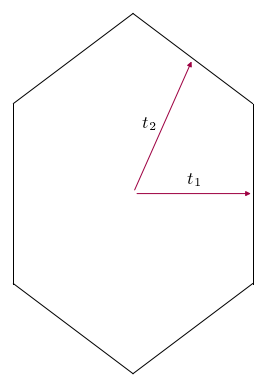

In [13]:
fig,axs = plt.subplots(figsize=(2*Lx,2*Ly))
for i in range(N_C):
    for j in range(i+1,N_C):
        r = carbon_atoms[i]-carbon_atoms[j]
        if np.abs(np.sqrt(r[0]**2 + r[1]**2) - aₒ*(1+cδ)) < 0.3:
            axs.plot([carbon_atoms[i,0],carbon_atoms[j,0]],[carbon_atoms[i,1],carbon_atoms[j,1]], 'k-', lw=0.5)
            
axs.text(0.6,0.15,r'$t_1$', va='center', ha='center')
axs.text(0.155,0.7,r'$t_2$', va='center', ha='center')


axs.annotate("", xy=(1.17902864/1.99, 2.6625/1.99), xytext=(0, 0), arrowprops=dict(arrowstyle="-|>",lw=0.5,mutation_scale=5,color=colors[-1]))
axs.annotate("", xy=(1.2, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="-|>",lw=0.5,mutation_scale=5,color=colors[-1]))

axs.axis('equal')
axs.axis('off')